In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
import warnings
import ast
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
import os
import seaborn as sns
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, Ridge

from sklearn.metrics import mean_squared_error as MSE

from imblearn.over_sampling import SMOTE

from Utils.UtilsGeoViz import *
from Utils.UtilsViz import *
from Utils.DataUtils import *

RANDOM_SEED = 42

In [4]:
data_path = os.path.join(os.getcwd(), "../data/cleaned_listings_with_outliers.csv")
listings = pd.read_csv(data_path, index_col="id")
display(listings.shape)

(50220, 65)

# Plot the distribution 

Text(0, 0.5, 'Price')

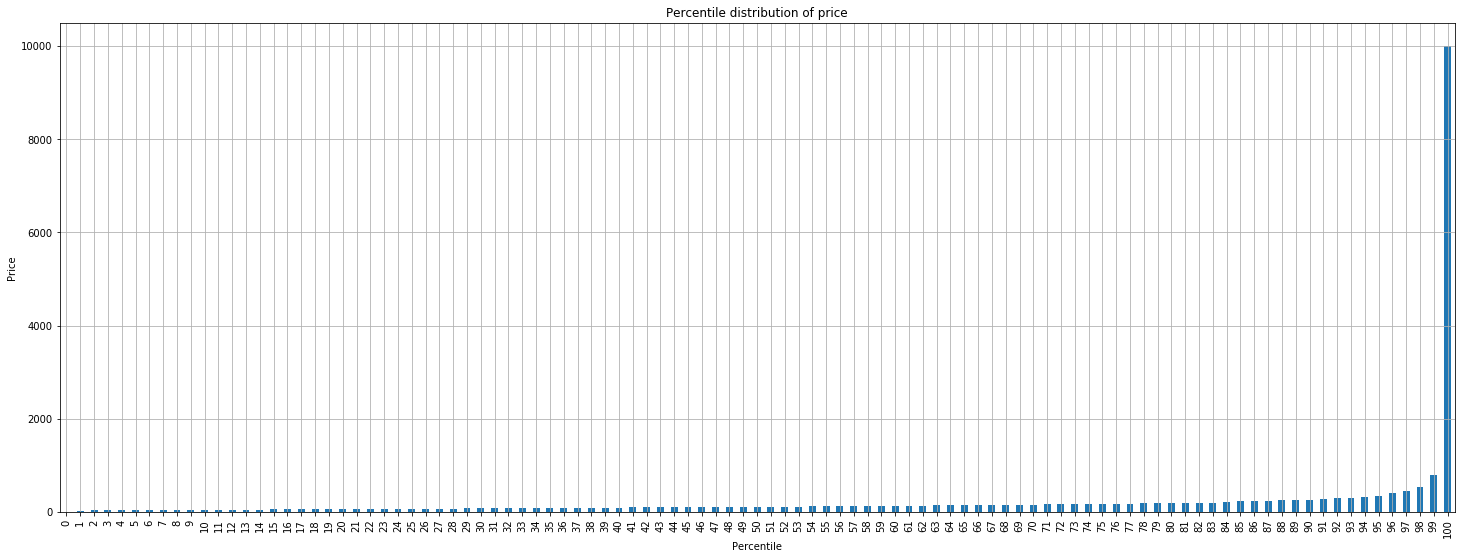

In [5]:
percentiles = list(range(0,101, 1))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(25,9), grid=True, legend=False)
plt.title("Percentile distribution of price")
plt.xlabel("Percentile")
plt.ylabel("Price")

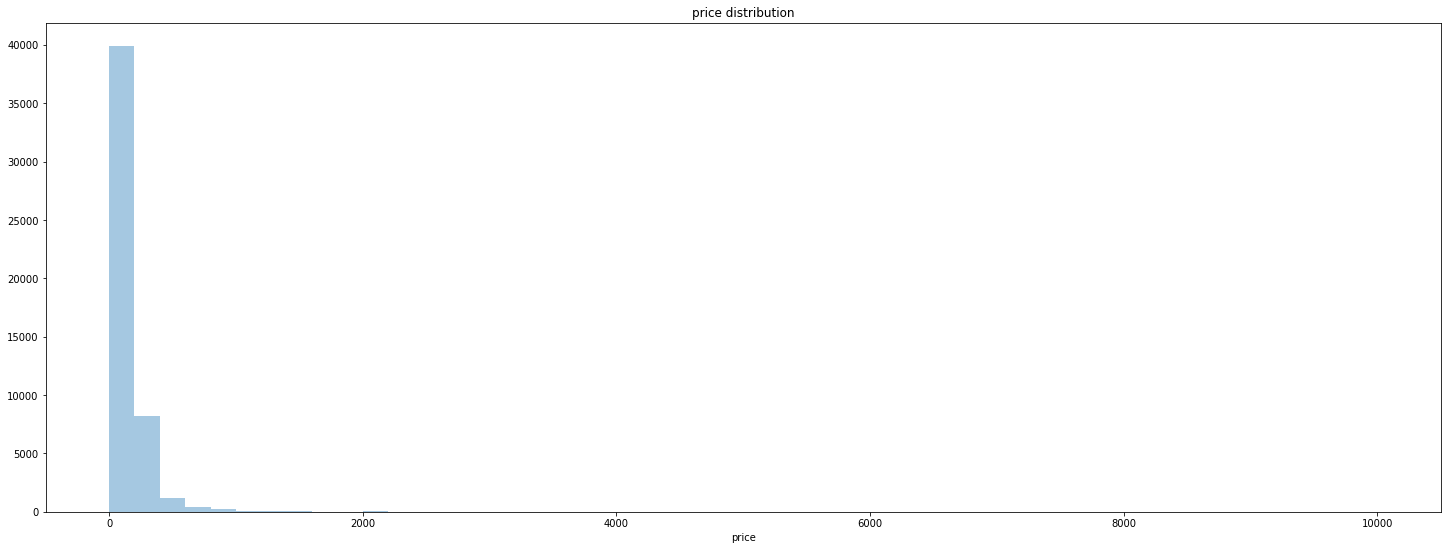

In [6]:
f, ax = plt.subplots(1,1,figsize=(25,9))
g = sns.distplot(a=listings["price"], kde=False)
t = g.set_title("price distribution")

# Round the prices to multiples of 5 

In [7]:
def roundto(row, base=5):
    return int(base * round(float(row) / base))
listings["price"] = listings["price"].apply(roundto)

# Train Test Split 

In [8]:
ycol = ["price"]
xcol = [i for i in listings.columns if i not in ycol]

x = listings[xcol].values
y = listings[ycol].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=RANDOM_SEED)

# Prediction 

Let's run a regressor of choice to establish a baseline 

In [9]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

d:\softwares\python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train set RMSE: 84.51
Test set RMSE: 230.98


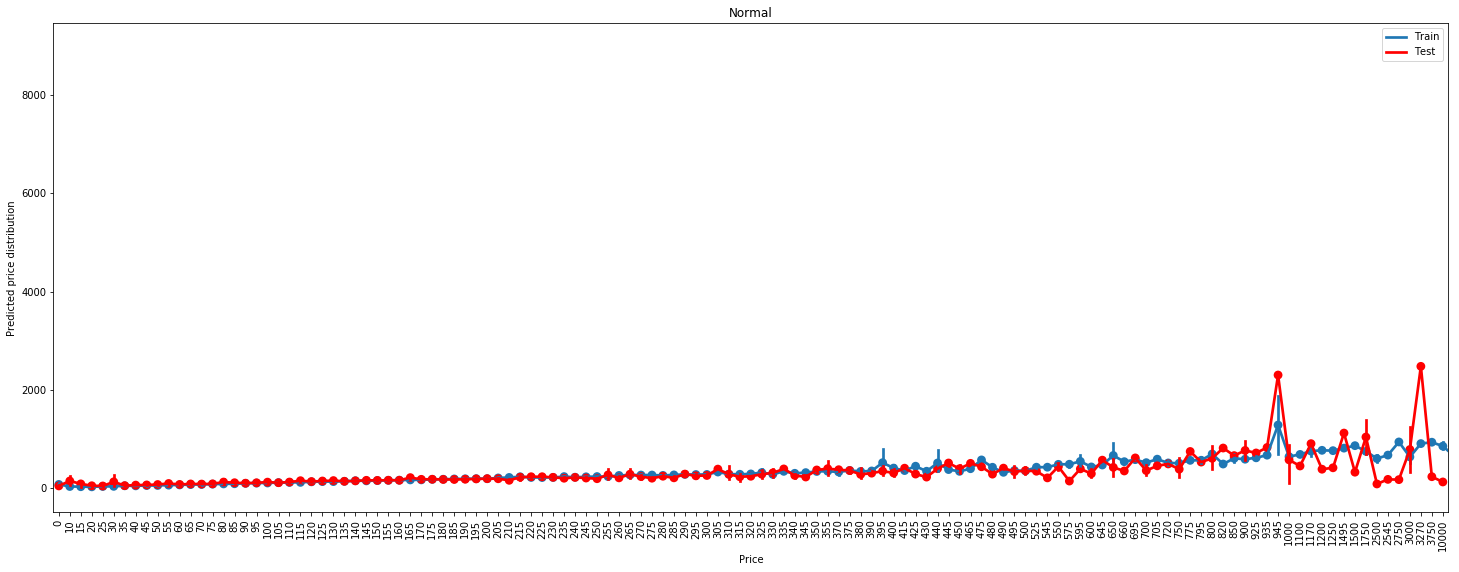

In [10]:
f, ax = plt.subplots(1,1, figsize=(25, 9), sharex=False)
# g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train.ravel()[::5], y=y_pred_train.ravel()[::5], ax=ax)
g = sns.pointplot(x=y_test.ravel()[::5], y=y_pred_test.ravel()[::5], ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")
# yl = g.set_ylim(0, 2000)
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])

----------

In [11]:
lasso = Lasso()
lasso.fit(X=x_train, y=y_train)
y_pred_train = lasso.predict(X=x_train)
y_pred_test = lasso.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 190.65
Test set RMSE: 224.78


d:\softwares\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


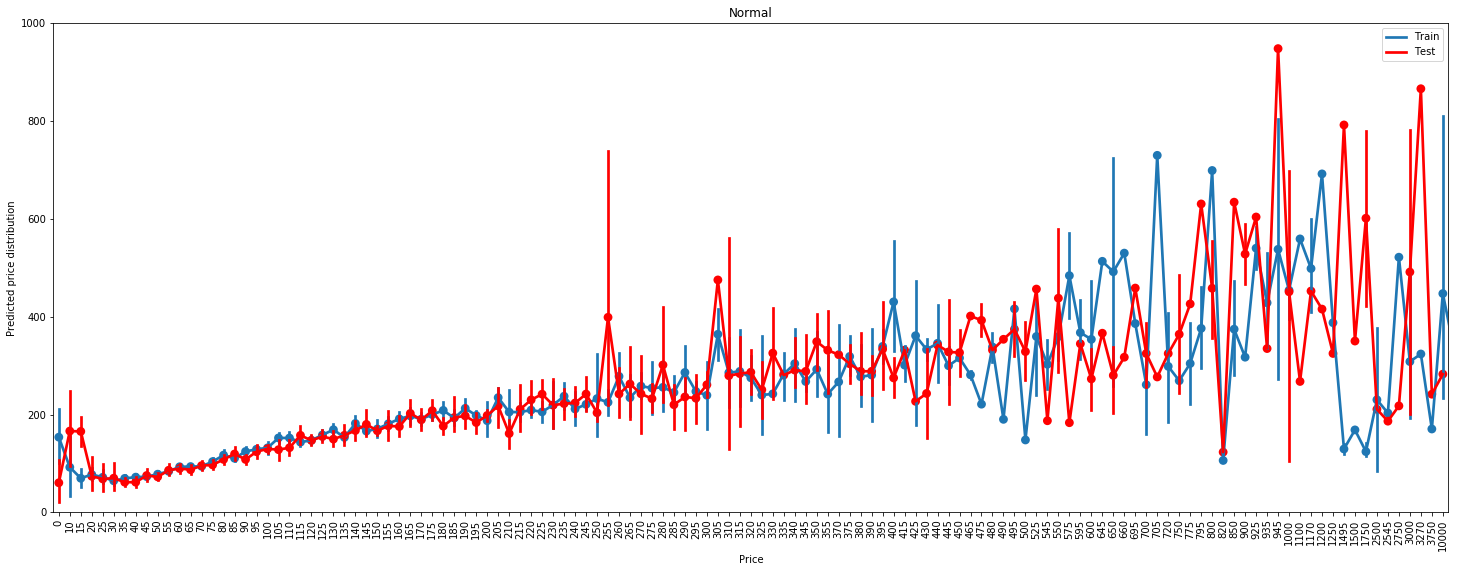

In [12]:
f, ax = plt.subplots(1,1, figsize=(25, 9), sharex=False)
# g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train.ravel()[::5], y=y_pred_train.ravel()[::5], ax=ax)
g = sns.pointplot(x=y_test.ravel()[::5], y=y_pred_test.ravel()[::5], ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")
yl = g.set_ylim(0, 1000)
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])

----------

In [13]:
ridge = Ridge()
ridge.fit(X=x_train, y=y_train)
y_pred_train = ridge.predict(X=x_train)
y_pred_test = ridge.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 189.67
Test set RMSE: 223.51


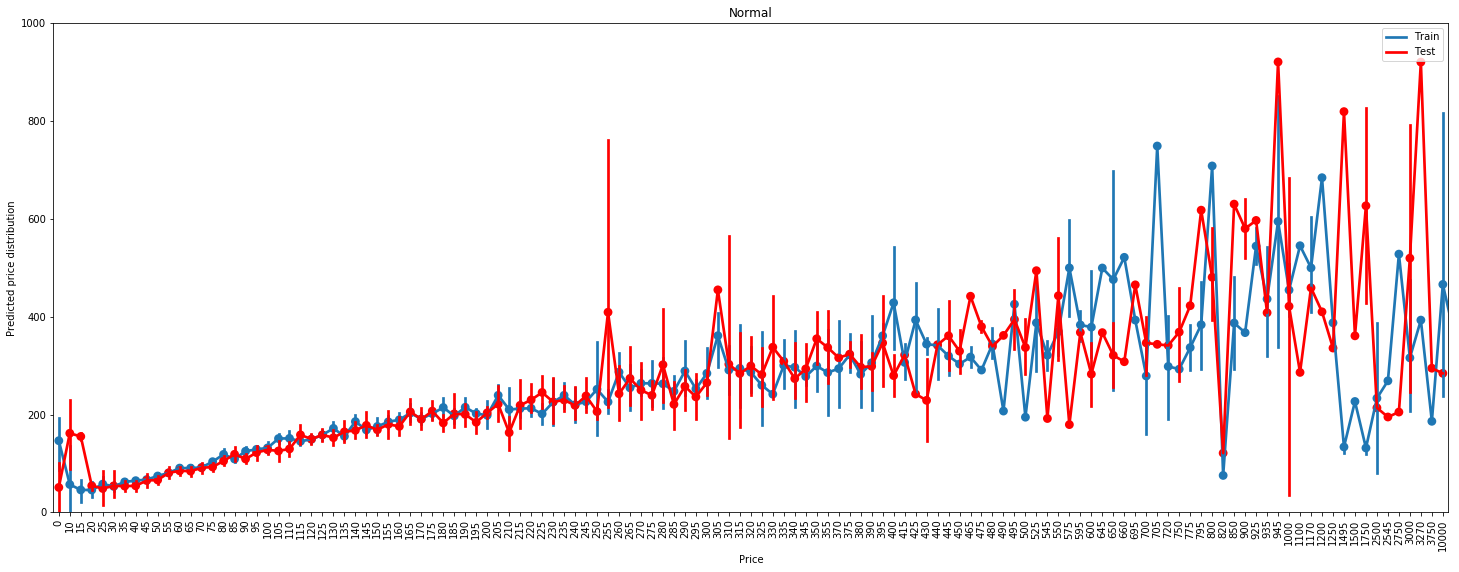

In [14]:
f, ax = plt.subplots(1,1, figsize=(25, 9), sharex=False)
# g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train.ravel()[::5], y=y_pred_train.ravel()[::5], ax=ax)
g = sns.pointplot(x=y_test.ravel()[::5], y=y_pred_test.ravel()[::5], ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")
yl = g.set_ylim(0, 1000)
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])

----------

In [21]:
gbr = GradientBoostingRegressor(n_estimators=400)
gbr.fit(X=x_train, y=y_train)
y_pred_train = gbr.predict(X=x_train)
y_pred_test = gbr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

d:\softwares\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train set RMSE: 118.46
Test set RMSE: 219.39


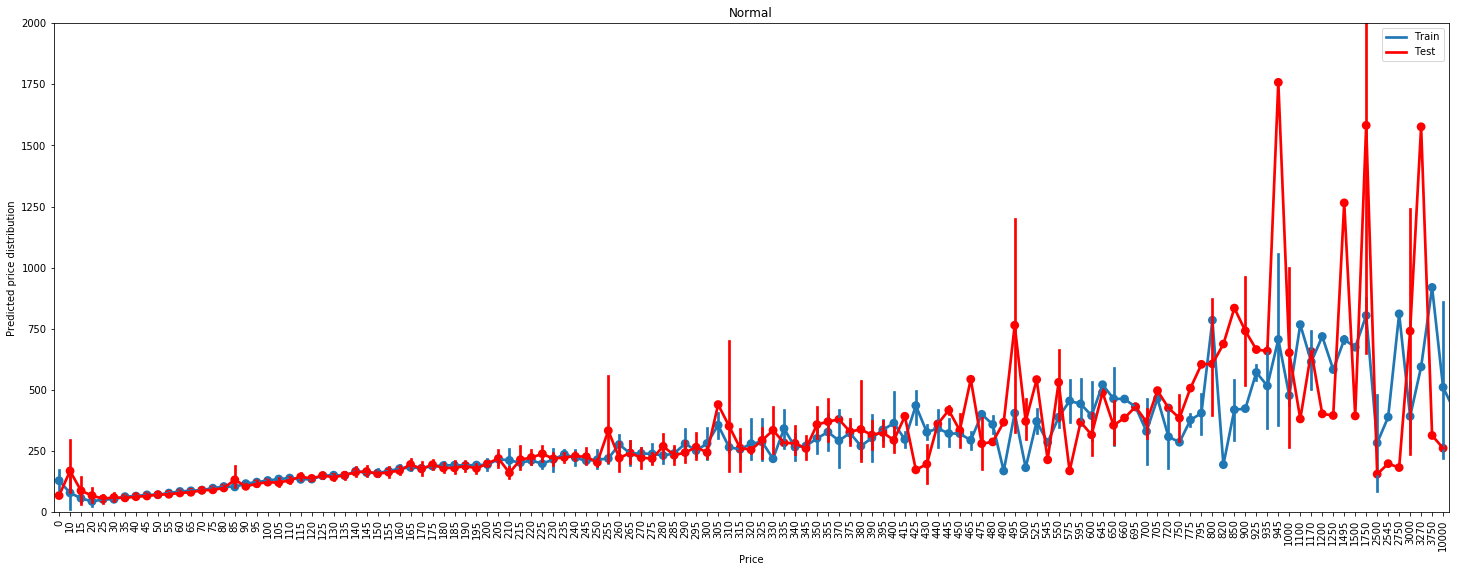

In [23]:
f, ax = plt.subplots(1,1, figsize=(25, 9), sharex=False)
# g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train.ravel()[::5], y=y_pred_train.ravel()[::5], ax=ax)
g = sns.pointplot(x=y_test.ravel()[::5], y=y_pred_test.ravel()[::5], ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")
yl = g.set_ylim(0, 2500)
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])

----------

In [18]:
dtr = DecisionTreeRegressor()
dtr.fit(X=x_train, y=y_train)
y_pred_train = dtr.predict(X=x_train)
y_pred_test = dtr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 2.11
Test set RMSE: 304.58


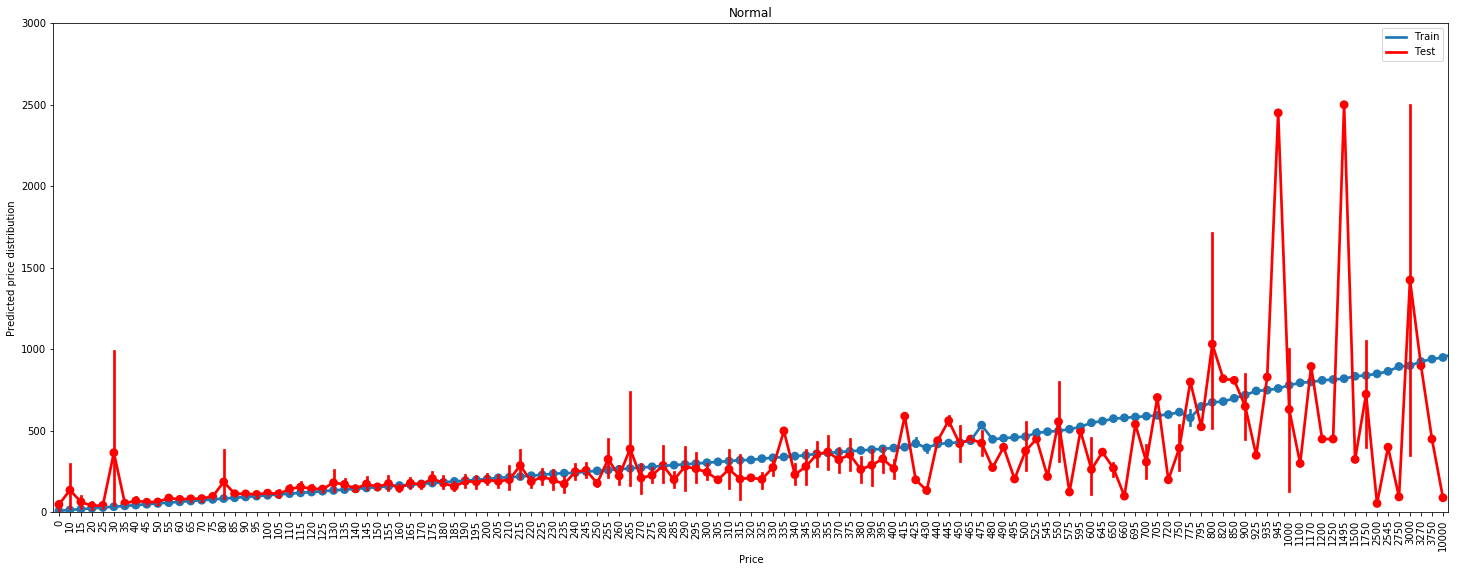

In [20]:
f, ax = plt.subplots(1,1, figsize=(25, 9), sharex=False)
# g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train.ravel()[::5], y=y_pred_train.ravel()[::5], ax=ax)
g = sns.pointplot(x=y_test.ravel()[::5], y=y_pred_test.ravel()[::5], ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")
yl = g.set_ylim(0, 3000)
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])